In [1]:
import os

from database import data_utils

import contextily as cx
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from shapely.ops import nearest_points

import importlib
importlib.reload(data_utils)

<module 'database.data_utils' from '/Users/zack/Desktop/valle/src/database/data_utils.py'>

In [2]:
kcm_sample = data_utils.combine_all_folder_data('../data/kcm_all/', n_sample=79)
atb_sample = data_utils.combine_all_folder_data('../data/atb_all/', n_sample=25)

In [3]:
# How many days are there
kcm_dates = len(os.listdir('../data/kcm_all/'))
atb_dates = len(os.listdir('../data/atb_all/'))
print(f"Number of observation days: KCM {kcm_dates}, NWY {atb_dates}")

Number of observation days: KCM 785, NWY 251


In [4]:
# How many observations are there total
kcm_num = len(kcm_sample)*10
atb_num = len(atb_sample)*10
print(f"Number of observed GPS points: KCM {kcm_num}, NWY {atb_num}")

Number of observed GPS points: KCM 323994720, NWY 5897850


In [5]:
# How many observations are there per day
kcm_per_day = kcm_num / kcm_dates
atb_per_day = atb_num / atb_dates
print(f"Number of points per day: KCM {kcm_per_day}, ATB {atb_per_day}")

Number of points per day: KCM 412732.127388535, ATB 23497.410358565736


In [6]:
# How many points per trajectory are there
kcm_points_per_trip = np.mean(kcm_sample.groupby(['file','tripid']).count()['vehicleid'])
atb_points_per_trip = np.mean(atb_sample.groupby(['file','datedvehiclejourney']).count()['vehicle'])
print(f"Average points per trajectory: KCM {kcm_points_per_trip}, ATB {atb_points_per_trip}")

Average points per trajectory: KCM 61.17263046597689, ATB 38.55055886005621


In [7]:
# How much lane mileage is covered
with open('../data/processed_networks/kcm_segments.pkl', 'rb') as f:
    kcm_segments = pickle.load(f)
    kcm_segments = kcm_segments.to_crs('EPSG:32148')
kcm_mileage = np.sum(kcm_segments.length) / 1000
with open('../data/processed_networks/nwy_segments.pkl', 'rb') as f:
    atb_segments = pickle.load(f)
    atb_segments = atb_segments.to_crs('EPSG:25833')
atb_mileage = np.sum(atb_segments.length) / 1000
print(f"Number of roadway kilometers: KCM {kcm_mileage}, ATB {atb_mileage}")

Number of roadway kilometers: KCM 3379.6733767345518, ATB 3968.8620889138206


In [8]:
# How much area is covered
kcm_bounds = kcm_segments.bounds
kcm_area = ((max(kcm_bounds.maxx) - min(kcm_bounds.minx)) / 1000) * ((max(kcm_bounds.maxy) - min(kcm_bounds.miny)) / 1000)
atb_bounds = atb_segments.bounds
atb_area = ((max(atb_bounds.maxx) - min(atb_bounds.minx)) / 1000) * ((max(atb_bounds.maxy) - min(atb_bounds.miny)) / 1000)
print(f"Total network area: KCM {kcm_area}, ATB {atb_area}")

Total network area: KCM 4175.795725848096, ATB 68549.12629797624


In [9]:
# How many vehicles are there total
kcm_veh = kcm_sample['vehicleid'].nunique()
atb_veh = atb_sample['vehicle'].nunique()
print(f"Estimated fleet size: KCM {kcm_veh}, ATB {atb_veh}")

Estimated fleet size: KCM 1451, ATB 784


In [10]:
# How many vehicles are active on a given day
kcm_veh_daily = np.mean(kcm_sample[['file','vehicleid']].groupby(['file']).nunique().values)
atb_veh_daily = np.mean(atb_sample[['file','vehicle']].groupby(['file']).nunique().values)
print(f"Average number of unique vehicles per day: KCM {kcm_veh_daily}, ATB {atb_veh_daily}")

Average number of unique vehicles per day: KCM 806.873417721519, ATB 213.72


In [11]:
# What is the activity across times of day
kcm_sample['date'] = pd.to_datetime(kcm_sample['locationtime'], unit='s', utc=True).map(lambda x: x.tz_convert('America/Los_Angeles'))
kcm_sample['hour'] = kcm_sample['date'].dt.hour
kcm_hourly = kcm_sample.groupby(['hour']).count()['tripid'] / kcm_dates
atb_sample['date'] = pd.to_datetime(atb_sample['locationtime'], unit='s', utc=True).map(lambda x: x.tz_convert('Europe/Oslo'))
atb_sample['hour'] = atb_sample['date'].dt.hour
atb_hourly = atb_sample.groupby(['hour']).count()['datedvehiclejourney'] / atb_dates
print(f"Average hourly observations: KCM {kcm_hourly}")
print(f"Average hourly observations: ATB {atb_hourly}")

Average hourly observations: KCM hour
0        0.298089
4        1.403822
5      157.951592
6     2629.268790
7     3336.159236
8     3361.735032
9     2984.915924
10    2748.770701
11    2916.407643
12    2978.143949
13    3021.030573
14    3149.536306
15    3419.452229
16    3773.954140
17    3839.596178
18    2954.588535
Name: tripid, dtype: float64
Average hourly observations: ATB hour
4       0.011952
5      10.665339
6      27.462151
7     561.035857
8     405.414343
9     151.482072
10    105.940239
11     86.625498
12     86.820717
13     84.649402
14    106.107570
15    135.227092
16    151.039841
17    158.298805
18    112.960159
19     84.617530
20     81.366534
21      0.015936
Name: datedvehiclejourney, dtype: float64


In [12]:
kcm_small_sample = data_utils.combine_all_folder_data('../data/kcm_all/', n_sample=14)
kcm_sample_traces = data_utils.calculate_trace_df(kcm_small_sample, 'file', 'tripid', 'locationtime', 'lat', 'lon', ['orientation','scheduledeviation','tripdistance','locationtime'], 'America/Los_Angeles', use_coord_dist=True)
atb_small_sample = data_utils.combine_all_folder_data('../data/atb_all/', n_sample=14)
atb_sample_traces = data_utils.calculate_trace_df(atb_small_sample, 'file', 'datedvehiclejourney', 'locationtime', 'lat', 'lon', ['bearing','locationtime'], 'Europe/Oslo', use_coord_dist=True)

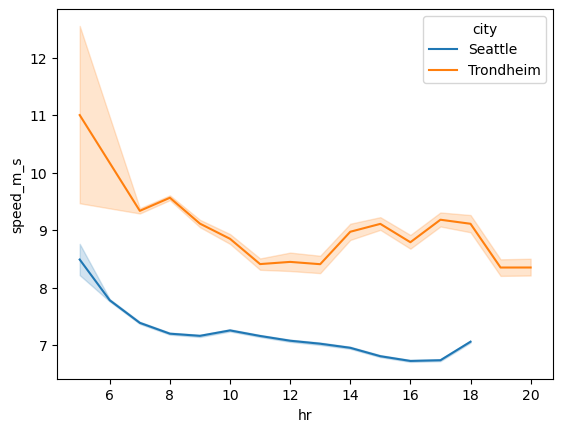

In [13]:
# What are speeds across times of the day
atb_sample_traces['hr'] = atb_sample_traces['datetime'].dt.hour
kcm_sample_traces['hr'] = kcm_sample_traces['datetime'].dt.hour
atb_sample_traces['city'] = 'Trondheim'
kcm_sample_traces['city'] = 'Seattle'

fig, ax = plt.subplots(1,1)
sns.lineplot(pd.concat([kcm_sample_traces[['city','hr','speed_m_s']], atb_sample_traces[['city','hr','speed_m_s']]]), x='hr', y='speed_m_s', hue='city')
plt.savefig("../plots/hourly_speeds.png", dpi=1800, bbox_inches='tight')

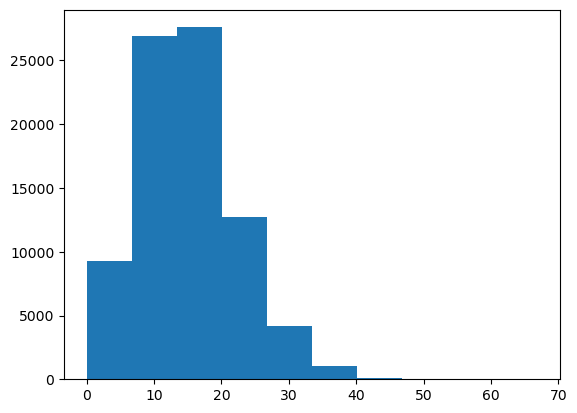

In [14]:
# What is the distribution of trip distances
fig, ax = plt.subplots(1,1)
plt.hist(kcm_sample_traces.groupby(['file','tripid']).max()[['dist_cumulative']])
plt.savefig("../plots/kcm_distance_dist.png", dpi=1800, bbox_inches='tight')

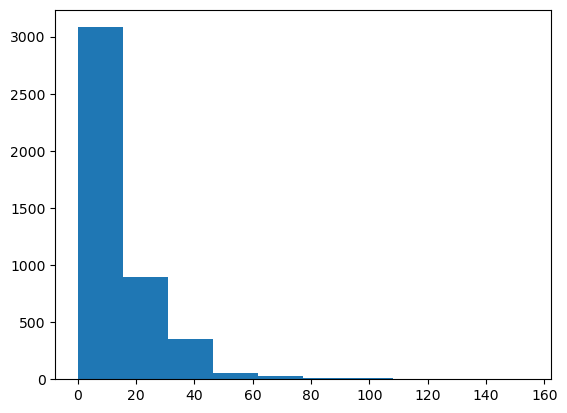

In [15]:
fig, ax = plt.subplots(1,1)
plt.hist(atb_sample_traces.groupby(['file','datedvehiclejourney']).max()[['dist_cumulative']])
plt.savefig("../plots/atb_distance_dist.png", dpi=1800, bbox_inches='tight')

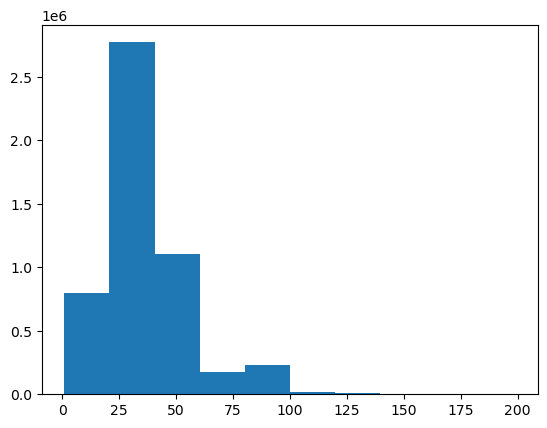

In [16]:
# What is the distribution of update frequencies
x = kcm_sample_traces[kcm_sample_traces['locationtime_diff']<200]

fig, ax = plt.subplots(1,1)
plt.hist(x[['locationtime_diff']])
plt.savefig("../plots/kcm_freq_dist.png", dpi=1800, bbox_inches='tight')

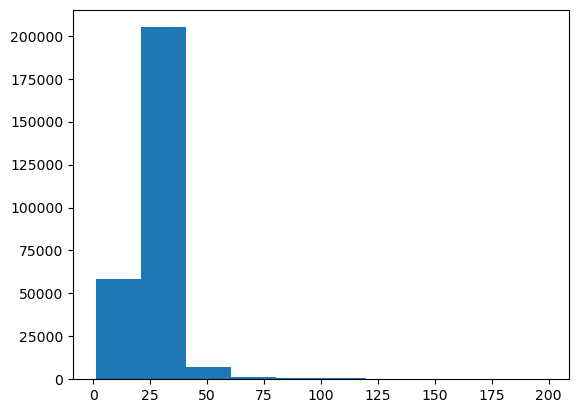

In [17]:
x = atb_sample_traces[atb_sample_traces['locationtime_diff']<200]

fig, ax = plt.subplots(1,1)
plt.hist(x[['locationtime_diff']])
plt.savefig("../plots/atb_freq_dist.png", dpi=1800, bbox_inches='tight')